In [1]:
from captum.attr import IntegratedGradients, Saliency, DeepLift
from NNModel import MultiLayerNN
from captum.attr import visualization as viz
import numpy as np
import pickle
import torch
import torch.nn as nn
from prep_data import prep_data
import matplotlib.pyplot as plt

# Data Prep

In [2]:
train_loader, test_loader = prep_data()
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [3]:
state_dict = torch.load("../data/model.pt", weights_only=True)
new_dict = {}
#When model compiles, all weights are modified from LAYERNAME to _orig_model.LAYERNAME. We remove the _orig_model. for compatibility
for k in state_dict.keys():
    new_dict[k[10:]] = state_dict[k]
model = MultiLayerNN(latent_size=128, num_layers=3)
model.load_state_dict(new_dict)
model.to(device)

MultiLayerNN(
  (dim_reduction): Linear(in_features=784, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [4]:
with open("../data/incorrect_preds.pkl", "rb") as f:
    incorrect_preds = pickle.load(f)

2 7


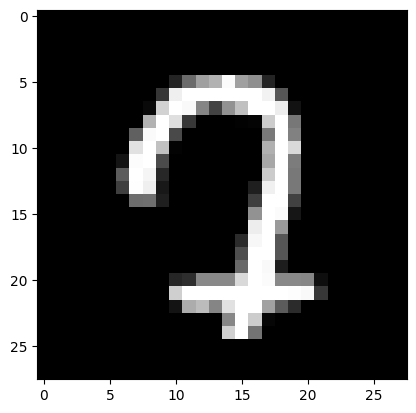

In [5]:
plt.imshow(incorrect_preds[0][0].squeeze(), cmap="gray")
print(incorrect_preds[0][1], incorrect_preds[0][2])

In [6]:
# Instantiate the attribution algorithm
# Get a single image and label from the test set
input_imgs = torch.stack([torch.tensor(imgs) for imgs, *_ in incorrect_preds])
predicted_labels = torch.tensor([labels for _ , labels, _ in incorrect_preds])
true_labels = torch.tensor([labels for _, _, labels in incorrect_preds])

# Gradient Attributions

In [7]:
len(incorrect_preds)

294

In [8]:
ig = IntegratedGradients(model)
final_attributions = torch.zeros_like(input_imgs.squeeze())
for i in range(0, input_imgs.shape[0], 100):
    input_img = input_imgs[i:i+100].to(device)
    labels = predicted_labels.to(device)

    # Get the model's prediction
    output = model(input_img.reshape(-1, 28 * 28))
    pred_probs = nn.functional.softmax(output, dim=1)
    pred_classes = torch.argmax(pred_probs, dim=-1)
    baseline = torch.zeros_like(input_img.reshape(-1, 28*28)).to(device)

    # Calculate attributions using Integrated Gradients
    # The target is the predicted class index
    attributions_ig = ig.attribute(input_img.reshape(-1, 28*28), baselines=baseline, target=pred_classes)
    final_attributions[i:i+100] = attributions_ig.detach().cpu().reshape(-1, 28, 28)
#pred_class = pred_classes[0].item()

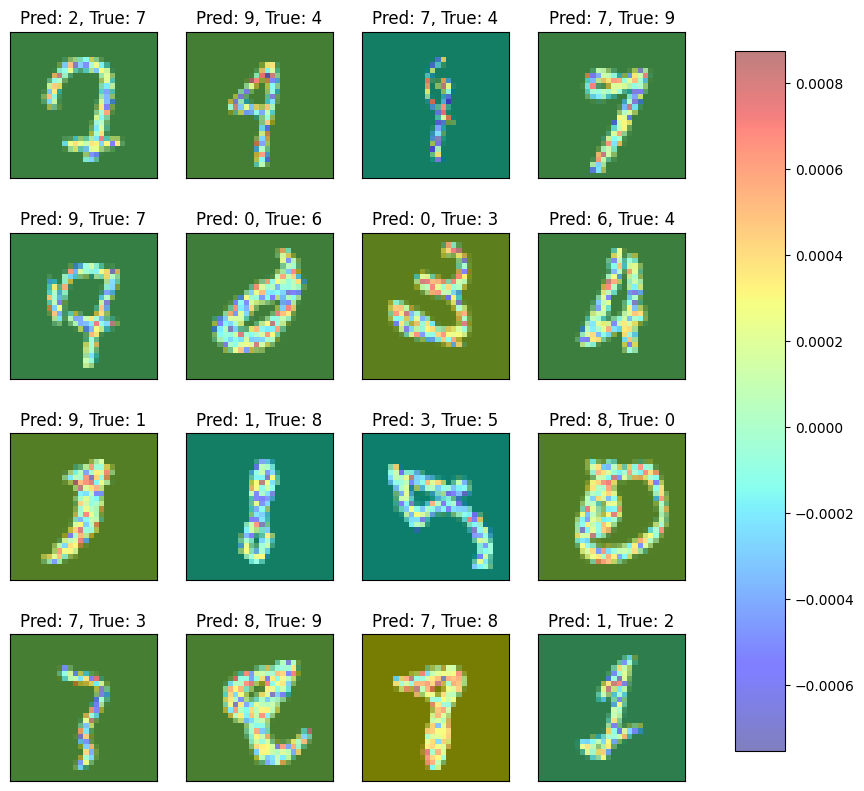

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(16):
    j=i #allows for "offset views" instead of only the first 16 numbers
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    original_image, pred_class, true_class = incorrect_preds[j]
    axes[i].imshow(original_image.squeeze(), cmap="gray")
    im = axes[i].imshow(final_attributions[j].squeeze().reshape(28, 28).cpu(), cmap="jet", alpha=0.5)
    axes[i].set_title(f"Pred: {pred_class}, True: {true_class}")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)